In [87]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier

from mlxtend.evaluate import confusion_matrix 
from mlxtend.plotting import plot_confusion_matrix 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from imblearn.over_sampling import SMOTE

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
#from google.colab import files
#uploaded = files.upload()

In [90]:
# Cargamos los datos con los que vamos a realizar el estudio
raw_data = pd.read_csv('/content/drive/MyDrive/train.csv', sep=',')

In [91]:
raw_data.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14:11:09,AR,55379,PAID,2,11.88,DeliveredStatus
1,33107339,11:47:41,GT,23487,PAID,2,5.20,DeliveredStatus
2,32960645,11:53:53,CR,62229,PAID,1,6.03,DeliveredStatus
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
4,32157739,21:32:16,AR,13917,PAID,1,5.36,CanceledStatus


In [92]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54330 entries, 0 to 54329
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        54330 non-null  int64  
 1   local_time      54330 non-null  object 
 2   country_code    54330 non-null  object 
 3   store_address   54330 non-null  int64  
 4   payment_status  54330 non-null  object 
 5   n_of_products   54330 non-null  int64  
 6   products_total  54330 non-null  float64
 7   final_status    54330 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 3.3+ MB


In [93]:
raw_data.describe()

,order_id,store_address,n_of_products,products_total
count,5.433000e+04,54330.000000,54330.000000,54330.000000
mean,3.278267e+07,41609.384981,2.815792,9.838136
std,4.459402e+05,21903.267141,2.430936,9.260352
min,3.150378e+07,190.000000,1.000000,0.000000
25%,3.240007e+07,21369.000000,1.000000,4.130000
50%,3.278159e+07,45993.500000,2.000000,7.130000
75%,3.318380e+07,62004.000000,3.000000,12.770000
max,3.356085e+07,75236.000000,39.000000,221.480000


In [94]:
# rápida inspección de si tenemos NaN o similar, vemos que no
raw_data.isnull().values.any()

False

In [95]:
# Por comodidad y comprensión, rebautizo nombres a las columnas...

data= raw_data.rename(columns={'order_id': 'id','local_time':'hora', 'country_code': 'pais','store_address': 'tienda',
                        'payment_status':'pago','n_of_products':'n_productos','products_total':'eur','final_status':'target'})

data.head()

,id,hora,pais,tienda,pago,n_productos,eur,target
0,33446280,14:11:09,AR,55379,PAID,2,11.88,DeliveredStatus
1,33107339,11:47:41,GT,23487,PAID,2,5.20,DeliveredStatus
2,32960645,11:53:53,CR,62229,PAID,1,6.03,DeliveredStatus
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
4,32157739,21:32:16,AR,13917,PAID,1,5.36,CanceledStatus


Con esto, podemos empezar a responder las preguntas que se nos plantean...

**1. ¿Cuáles son los 3 paises en los que más pedidos se realizan?**

Podemos responder a esta pregunta de manera cualitativa con un simple histograma del número de pedidos para cada país, tal y como se muestra a continuación.




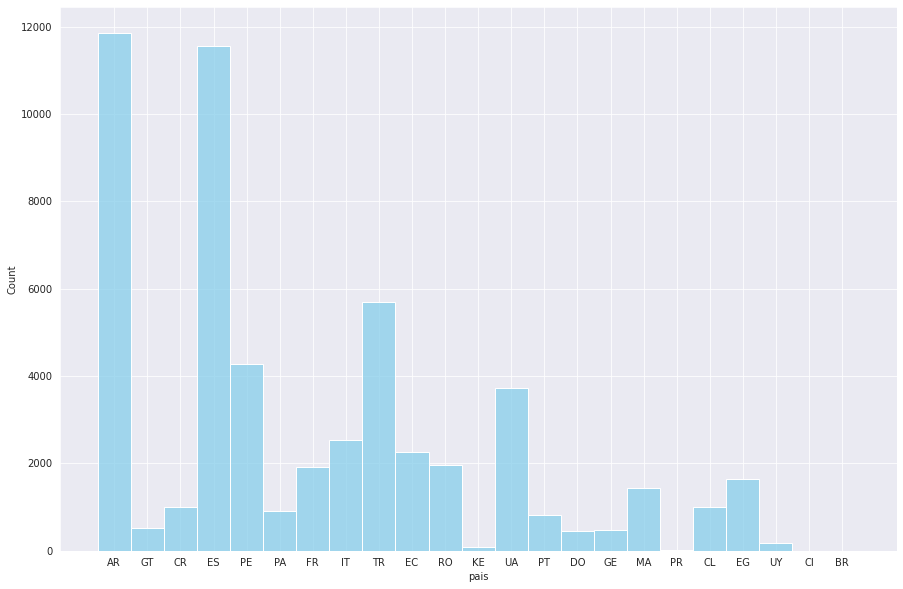

In [96]:
plt.figure(figsize=(15,10))
sns.set_style("darkgrid")
sns.histplot(x="pais",data=data,color='skyblue')



In [97]:
# O bien, de manera cuantitativa, mirando exactamente el número de pedidos para cada país:
data['pais'].value_counts()

AR    11854
ES    11554
TR     5696
PE     4284
UA     3729
IT     2537
EC     2265
RO     1957
FR     1911
EG     1643
MA     1446
CR     1000
CL      994
PA      909
PT      818
GT      511
GE      485
DO      448
UY      169
KE       84
PR       29
CI        6
BR        1
Name: pais, dtype: int64

Analizando estos resultados podemos concluir que claramente los 3 países en los que se realizan más son, de mayor a menor, Argentina (AR), España (ES) y Turquía (TR).

2**. ¿Cuáles son las horas en las que se realizan más pedidos en España?**

Para responder a esta pregunta, analizamos por separado un sub-set correspondiendo a los pedidos realizados en España.

In [98]:
spain= data[data['pais']== 'ES'].copy()
#data_spain.head()

Necesitamos realizar alguna manipulación con la columna de las horas (columna temporal). En primer lugar, empleamos la función propia de Pandas 'to_dadetime' que nos permite tener esta columna en un formato adecuado para realizar transformaciones.

In [99]:
# Hacemos una transformación

spain["hora"] = pd.to_datetime(spain["hora"])
#data_spain.info()
spain.head()

,id,hora,pais,tienda,pago,n_productos,eur,target
3,32089564,2021-11-28 20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
8,32236610,2021-11-28 17:09:16,ES,30120,PAID,3,4.35,DeliveredStatus
13,32235607,2021-11-28 18:02:18,ES,18682,PAID,9,16.12,DeliveredStatus
19,32670668,2021-11-28 14:37:58,ES,8994,PAID,12,17.93,DeliveredStatus
24,32126718,2021-11-28 21:12:30,ES,14872,PAID,3,22.00,DeliveredStatus


Aparentemente se ha complicado la columna de los tiempos, pero con este formato ahora somos capaces de seleccionar los elementos que únicamente nos interesan. En este caso es claro que queremos responder a las **horas** de mayor demanda, por lo tanto, podemos prescindir del resto de información. 

Observamos que disponemos también de los minutos y los segundos, pero, en una primera aproximación (y realmente buena, dado que buscamos rangos de hora) podemos prescindir de los segundos y basarnos exclusivamente en las horas y minutas como franjas de tiempo absolutas (realmente la información de los segundos aporta nula información de valor para nuestros intereses, dado que no necesitamos ese orden de precisión).
Este razonamiento es lo que realizamos a continuación.


In [100]:
spain["h"] = spain["hora"].dt.hour # de la columna tiempo ('hora') me quedo sólo con las horas
spain["m"] = spain["hora"].dt.minute # generamos nueva columna con los minutos de cada pedido

spain['m'] = spain['m']/60 # conversión de minutos a horas de la columna generada 'm' para unificar unidades del tiempo en horas
spain['t'] = spain['h']+spain['m'] # suma de ambos tiempos para tener una columna con la hora del pedido con una precisión del minuto


spain= spain.drop(['hora','h','m'], axis=1) # eliminamos las columnas de horas y minutos por separado que ya no nos sirven

#inspección final de que todo esta ok
spain.head()


,id,pais,tienda,pago,n_productos,eur,target,t
3,32089564,ES,29446,PAID,6,6.37,DeliveredStatus,20.250000
8,32236610,ES,30120,PAID,3,4.35,DeliveredStatus,17.150000
13,32235607,ES,18682,PAID,9,16.12,DeliveredStatus,18.033333
19,32670668,ES,8994,PAID,12,17.93,DeliveredStatus,14.616667
24,32126718,ES,14872,PAID,3,22.00,DeliveredStatus,21.200000


Ahora tenemos el tiempo en un formato adecuado, tenemos una precisión del minuto (más que suficiente para nuestro estudio) y lo tenemos expresado como una variable continua, como debe ser.

Podemos realizar un histograma para ver la distribución de las ventas según la hora.

Text(0.5, 1.0, 'Pedidos España por franja horaria')

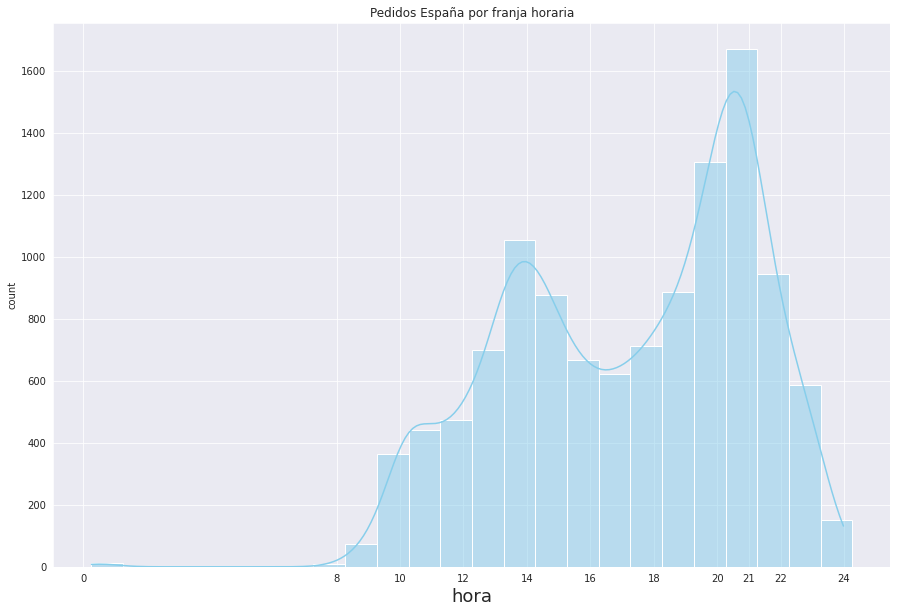

In [101]:
plt.figure(figsize=(15,10))
sns.set_style("darkgrid")
sns.histplot(x="t",data=spain,color='skyblue', binwidth=1, kde = True) # le añadimos una función de densidad de probabilidad (kde, kernel density estimation)para estimar el fit
plt.xticks([0,8,10,12,14,16,18,20,21,22,24])
#plt.xticks(np.arange(0, 24, step=1))
plt.xlabel('hora', fontsize=18)
plt.ylabel('count')
plt.title('Pedidos España por franja horaria')


Esta visualización nos permite concluir que tenemos claramente un pico de pedidos entre las 20 y las 21 de la noche, siendo esta franja horaria por lo tanto la que registra el mayor número de pedidos.
Gracias al fit de la distribución de densidad ajustado a nuestros datos podemos ver con claridad un segundo pico de orden menor que se situaría entre las 14 y las 15 de la tarde, siendo esta la segunda franja horaria en la que más pedidos se registran.

3. **¿Cuál es el precio medio por pedido en la tienda con ID 12513?**

Creamos primero sub-dataset con los pedidos vinculados únicamente a la tienda con ID 12513 y a continuación calculamos la media de manera analítica.

In [102]:
data_12513 = data[data['tienda']==12513]
#data_12513.head()

precio_medio = data_12513['eur'].mean()

print('El precio medio en la tienda ID 12513 son:', precio_medio, 'eur')

El precio medio en la tienda ID 12513 son: 17.392244897959173 eur


4. **Qué porcentaje de repartidores pondrías por cada turno para que sean capaces de hacer frente a los picos de demanda. (ej: Turno 1 el 30%, Turno 2 el 10% y Turno 3 el 60%**

En primer lugar, recordamos los turnos de 8 horas especificados en el enunciado.

- Turno 1 (00:00-08:00)
- Turno 2 (08:00-16:00)
- Turno 3 (16:00-00:00)



In [103]:
# el precio medio por pedido en la tienda id=12513 son aprox 17,40 eur


#para repartidores en España:
#Turno 1 (00:00-08:00)
#Turno 2 (08:00-16:00)
#Turno 3 (16:00-00:00)

En primer lugar, vamos a ver cómo se reparten los turnos para cada uno de los pedidos, para ellos asignamos, bajo las condiciones impuestas por el enunciado, a cada pedido un turno determinado de los tres posibles, esto es lo que hacemos a continuación.

In [104]:
# Implementamos las condiciones de los turnos según las horas
condiciones = [
              (spain['t'] > 0) & (spain['t'] <= 8),
              (spain['t'] > 8) & (spain['t'] <= 16),
              (spain['t'] > 16) & (spain['t'] <= 24) 
              ]

 
# Creamos una lista de los valores (o categorías en nuestro caso) que queremos asignar a cada condición 
values = ['turno 1', 'turno 2', 'turno 3']

# creamos una nueva columna y usamosla función 'select' de numpy para asignarle valores usando la lista definida como argumento
spain['turno'] = np.select(condiciones, values)


pd.set_option('display.max_rows', None)

spain.head()



,id,pais,tienda,pago,n_productos,eur,target,t,turno
3,32089564,ES,29446,PAID,6,6.37,DeliveredStatus,20.250000,turno 3
8,32236610,ES,30120,PAID,3,4.35,DeliveredStatus,17.150000,turno 3
13,32235607,ES,18682,PAID,9,16.12,DeliveredStatus,18.033333,turno 3
19,32670668,ES,8994,PAID,12,17.93,DeliveredStatus,14.616667,turno 2
24,32126718,ES,14872,PAID,3,22.00,DeliveredStatus,21.200000,turno 3


A continuación podemos ver cómo quedan repartidos los pedidos según estos turnos definidos, mediante el siguiente histograma.

turno 1
14
turno 2
4501
turno 3
7039


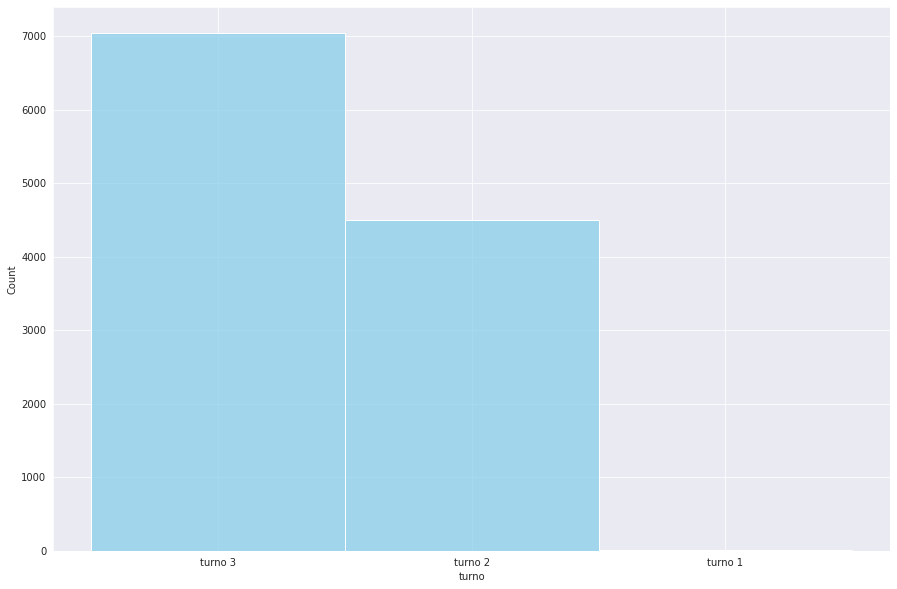

In [105]:
#histograma
plt.figure(figsize=(15,10))
sns.histplot(x='turno', data=spain, color='skyblue')

#número exacto de pedidos para cada turno:

print('turno 1')
print(len(spain[spain['turno']=='turno 1']))

print('turno 2')
print(len(spain[spain['turno']=='turno 2']))

print('turno 3')
print(len(spain[spain['turno']=='turno 3']))


Lo que se puede observar aquí es que se tiene una minoría de pedidos (14) que pertenecen al turno 1, mediante que en el turno 2 se realizan un total de 4501 pedidos y el turno 3 es el que recoge mayor cantidad de pedidos llegando a los 7039.

En realidad esta conclusión no es nada nueva, si tenemos en cuenta que anteriormente razonamos que el pico de pedidos se situaba entre las 20 y las 21, intervalo de tiempo que pertenecería al turno 3.
El segundo mayor pico, tras el pico principal perteneciente al turno 3, se sitúa sobre las 14 de la tarde, que correspondería al turno 2, lo cual va en línea con las conclusiones extraídas en el punto 2 acerca de los principales picos de picos de ventas.



In [106]:
# Analíticamente, vamos la representación en % de estos turnos respecto el global de pedidos

print('turno 1 %')
print(len(spain[spain['turno']=='turno 1'])*100/len(spain))

print('turno 2 %')
print(len(spain[spain['turno']=='turno 2'])*100/len(spain))

print('turno 3 %')
print(len(spain[spain['turno']=='turno 3'])*100/len(spain))

turno 1 %
0.12117015752120477
turno 2 %
38.956205643067335
turno 3 %
60.92262419941146


Por lo tanto, de acuerdo a la distribución en importancia de los turnos y teniendo en cuenta los principales picos de ventas, una opción interesante de cara a la distribución de los trabajadores en los turnos podría ser la que se propone a continuación: 

- Turno 3. El 61% de los trabajadores en este turno. Este es el turno donde mayor cantidad de pedidos se realizan, registrándose en él el pico principal de ventas.

- Turno 2. El 38% de la plantilla ubicada en este turno. Este turno se corresponde con el segundo turno de mayor trabajo y registra el segundo mayor pico de pedidos solicitados.

- Turno 1. El 1% de los trabajadores en este turno. Es el turno que registra con diferencia la cantidad de pedidos por lo tanto colocando al 1% de la plantilla en este turno sería más que suficiente para hacer frente a los pedidos que se solicitan en esta franja horaria.


5. **Modelo de Machine Learning** 

El objetivo es diseñar un modelo predictivo que determine si el pedido se acabará entregando o cancelando (target ='final_status').

Rescatamos primero el conjunto de datos con los que vamos a trabajar.

In [107]:
df = data.copy()
df.head()

,id,hora,pais,tienda,pago,n_productos,eur,target
0,33446280,14:11:09,AR,55379,PAID,2,11.88,DeliveredStatus
1,33107339,11:47:41,GT,23487,PAID,2,5.20,DeliveredStatus
2,32960645,11:53:53,CR,62229,PAID,1,6.03,DeliveredStatus
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
4,32157739,21:32:16,AR,13917,PAID,1,5.36,CanceledStatus


Ahora realizamos las mismas transformaciones que hicimos anteriormente a la variable tiempo con el fin de tener una variable continua apta para incluir en los modelos predictivos y en las que nos quedamos con una precisión del minuto (como se argumentó anteriormente, trabajar con precisiones del segundo no va a mejorar las métricas de nuestros modelos desarrollados).

- DATA PREPROCESSING

In [108]:
df["hora"] = pd.to_datetime(df["hora"])
df["h"] = df["hora"].dt.hour
df["m"] = df["hora"].dt.minute/60
df['t'] = df['h']+df['m']
df= df.drop(['hora','h','m'], axis=1)
df.head()

,id,pais,tienda,pago,n_productos,eur,target,t
0,33446280,AR,55379,PAID,2,11.88,DeliveredStatus,14.183333
1,33107339,GT,23487,PAID,2,5.20,DeliveredStatus,11.783333
2,32960645,CR,62229,PAID,1,6.03,DeliveredStatus,11.883333
3,32089564,ES,29446,PAID,6,6.37,DeliveredStatus,20.250000
4,32157739,AR,13917,PAID,1,5.36,CanceledStatus,21.533333


- DATA-TARGET ENCODED

Nuestra función objetivo o target es la variable 'final_status', que ahora la escribiremos como 'status'.
Para poder trabajar correctamente con este target a través de los algoritmos de ML necesitamos codificarlo como una variable dicotómica.

En concreto, a los pedidos entregados les asignaremos el 'label' 1 y a los pedidos cancelados/no entregados les asignamos el 'label' 0.

In [109]:
df.loc[df['target'] =='DeliveredStatus' , 'status'] = '1'
df.loc[df['target'] =='CanceledStatus' , 'status'] = '0'
df= df.drop(['target'], axis=1)
df.head()

,id,pais,tienda,pago,n_productos,eur,t,status
0,33446280,AR,55379,PAID,2,11.88,14.183333,1
1,33107339,GT,23487,PAID,2,5.20,11.783333,1
2,32960645,CR,62229,PAID,1,6.03,11.883333,1
3,32089564,ES,29446,PAID,6,6.37,20.250000,1
4,32157739,AR,13917,PAID,1,5.36,21.533333,0


- Discusión sobre las variables 'tienda' y 'pago'

In [110]:
# el num de id del pedido es algo único para identificar el pedido, no tendrá ninguna relevancia para nuestro modelo, lo eliminamos...
df= df.drop(['id'], axis=1)
df.head()


,pais,tienda,pago,n_productos,eur,t,status
0,AR,55379,PAID,2,11.88,14.183333,1
1,GT,23487,PAID,2,5.20,11.783333,1
2,CR,62229,PAID,1,6.03,11.883333,1
3,ES,29446,PAID,6,6.37,20.250000,1
4,AR,13917,PAID,1,5.36,21.533333,0


Finalmente, analizamos la variable categórica 'pago', y podemos comprobar que tiene 3 niveles (paid, not_paid, delayed) y que la clase 'paid' supone el 99.12% de los casos. Por lo tanto podemos considerar en una primera (y buena) aproximación que la significancia estadística de esta variable será muy poco relevante y por lo tanto podremos prescindir de ella al tener un deslabance tan elevado, tal y como se muestra a continuación.

% paid
99.1238726302227
% not_paid
0.8650837474691699
% delayed
0.011043622308117063


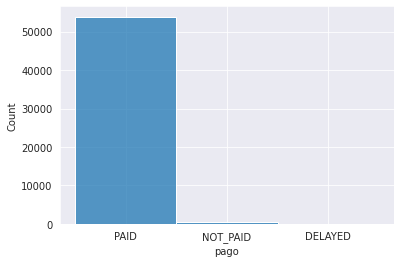

In [111]:
# analizamos la variable categórica PAGO

sns.histplot(data=df, x = 'pago')

print('% paid')
print(len(df[df['pago']=='PAID'])*100/len(df['pago']))
print('% not_paid')
print(len(df[df['pago']=='NOT_PAID'])*100/len(df['pago']))
print('% delayed')
print(len(df[df['pago']=='DELAYED'])*100/len(df['pago']))

# eliminamos columna 'pago'


df = df.drop(['pago'], axis=1)

In [112]:
# inspección del dataset actual tras el conjunto de modificaciones
df.head()

,pais,tienda,n_productos,eur,t,status
0,AR,55379,2,11.88,14.183333,1
1,GT,23487,2,5.20,11.783333,1
2,CR,62229,1,6.03,11.883333,1
3,ES,29446,6,6.37,20.250000,1
4,AR,13917,1,5.36,21.533333,0


- Tratamiento de la variable 'país'

Una pequeña discusión acerca de esta variable:

Se dispone de una columna correspondiente a los países donde se registran los pedidos.
Esta columna sin embargo es categórica, deberíamos de encontrar alguna forma de 'numerizarla' con el objetivo de poder introducirla en el modelo predictivo. Otra opción es directamente prescindir de ella.

Por otro lado, podríamos argumentar que en principio el hecho de que un pedido se acabe cancelando o entregando no debería estar influenciado por el país donde se realiza el pedido, algo que por otro lado tampoco podemos asegurar.

En este caso, procedemos a elegir eliminar esta variable.



PREPARACIÓN DE LOS DATOS PARA APLICAR MODELOS DE MACHINE LEARNING


In [113]:
# eliminamos columna 'país'
df = df.drop(['pais'], axis=1)

# Separamos el dataset entre las variables predictoras y el target (objetivo)
feature_cols = ['tienda', 'n_productos', 'eur', 't']

X = df[feature_cols] # Features (predictoras)
y = df['status'] # Target variable

Para poder testear los modelos, separamos el conjunto de datos en una parte para entrenar el algoritmo (train) y otra para validar su desempeño (test).
Podemos utilizar la librería scikit que con la funcionalidad 'train_test_split' hace esta partición del dataset de manera automática. En este caso, utilizaremos el 80% de los datos para entrenar el algoritmo y el 20% restante los utilizaremos para testearlo.

In [114]:
 # separación del dataset en train/test
 X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=31415) # le definimos una seed para que los resultados sean reproducibles

ANÁLISIS DEL TARGET 'STATUS'

Realizando una sencilla inspección a nuestra variable objetivo, nos damos cuenta de que tenemos un dataset considerablemente desbalanceado. En concreto, y tal y como se muestra a continuación, se observa que la clase 1 (pedidos entregados) supone el 89% del dataset, mientras que el 10.7% restante está conformado por la clase 0 correspondiente a los pedidos cancelados.



pedidos entregados 89.27 %
pedidos cancelados 10.73 %


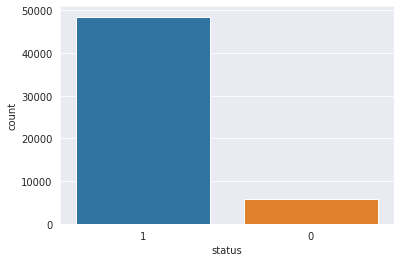

In [115]:
# análisis del desbalance de clases en la variable target 'status'

sns.countplot(data=df ,x = 'status')

print('pedidos entregados', round(len(df[df['status']=='1'])*100/len(df),2),'%')

print('pedidos cancelados', round(len(df[df['status']=='0'])*100/len(df),2),'%')

Imaginemos que no reparamos en este problema de desbalanceo de clases, podríamos aplicar diferentes modelos de machine learning para predecir nuestro target.

Evidentemente estamos ante un problema de clasificación, y por lo tanto podríamos hacer uso de clasificadores sencillos tales como una regresión logística, un algoritmo de primeros vecinos o KNN, un random forest o un algoritmo de árbol de decisión (ID3,C4.5,CART,etc).

A continuación lanzamos estos cuatro algoritmos y los comparamos en base a una determinada métrica de evaluación, que en este caso será el F1_score (macro).
Esta métrica es mucho más conveniente cuando estamos ante datasets desbalanceados, ya que no solo tiene en cuenta los errores en las predicciones (accuracy) sino que además tiene en cuenta el tipo de errores en dichas predicciones, en concreto, distingue el número de instancias correctamente clasificadas de cada clase dando una mejor medida por lo tanto que la precisión/accuracy.
 Además, cuando el número de falsos positivos y falsos negativos es realmente importante entonces la métrica f1 es también mucho más conveniente que la accuracy, siendo esta última más conveniente cuando los verdaderos positivos y verdaderos negativos son los de mayor relevancia.

In [116]:
# Implementamos weak's learners

classifiers = {
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "DecisionTreeClassifier CART": DecisionTreeClassifier()
}


# Evaluamos su desempeño en base a métrica f1_score y empleando la técnica 'cross_validation' como conjunto validación del resultado de la métrica

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1_macro')
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) , "f1 (macro) scoring")

Classifiers:  LogisticRegression Has a training score of 0.47 f1 (macro) scoring
Classifiers:  KNeighborsClassifier Has a training score of 0.53 f1 (macro) scoring
Classifiers:  RandomForestClassifier Has a training score of 0.51 f1 (macro) scoring
Classifiers:  DecisionTreeClassifier Has a training score of 0.54 f1 (macro) scoring


Lo que observamos del output de estos algoritmos es que todos ofrecen un desempeño en mayor o menor medida bastante similar.

Recordemos en primer lugar que el rendimiento del modelo es mejor en la medida que el f1_score tienda a 1, y en la medida que se acerque su valor a 0 indica un peor modelo. En ese sentido, el modelo que ofrece el peor resultado es la regresión logística, seguido del algoritmo Random Forest, KNN y finalmente el Decision Tree (corresponde al algoritmo CART, pues esta implementación corresponde a la que realiza la librería scikit, tal y como se puede consultar en su documentación).

Por lo tanto, decidimos seguir trabajando con el mejor modelo que ha sido el del árbol de decisión.

A continuación nos centramos únicamente en dicho modelo, lo volvemos a implementar y evaluar con mayor detalle...


In [117]:
# Definimos algoritmo clasificación
clf = DecisionTreeClassifier()

# Entrenamos algoritmo
clf = clf.fit(X_train,y_train)

# Predecimos labels set testeo
y_pred = clf.predict(X_test)

# Imprimimos un reporting de los resultados de la evaluación del algoritmo
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.19      0.21      0.20      1210
           1       0.90      0.89      0.89      9656

    accuracy                           0.81     10866
   macro avg       0.55      0.55      0.55     10866
weighted avg       0.82      0.81      0.82     10866



Podemos intentar eliminar la varianza de este modelo y ganar más robustez empleando técnicas como el 'Bagging', ya implementadas en el paquete scikit.

In [118]:
# defino modelo de bagging (basado en nuestro estimador incial básico 'clf')
clf_bagg = BaggingClassifier(base_estimator=clf)

#entrenamos modelo bagg
clf_bagg = clf_bagg.fit(X_train,y_train)

#predecimos niveles set testeo
y_pred_bagg = clf_bagg.predict(X_test)

# Imprimimos un reporting de los resultados de la evaluación del algoritmo
print(metrics.classification_report(y_test, y_pred_bagg))

              precision    recall  f1-score   support

           0       0.29      0.10      0.15      1210
           1       0.90      0.97      0.93      9656

    accuracy                           0.87     10866
   macro avg       0.59      0.54      0.54     10866
weighted avg       0.83      0.87      0.84     10866



Gracias al uso de un meta-algoritmo como Bagging hemos sido capaces de reducir la varianza o el overfiting de nuestro modelo inicial. En este sentido, estos resultados obtenidos son de mayor robustez. 

Analizando pues el reporting del meta-algoritmo Bagging observamos una mejora en el f1_score que se sitúa en 0.59, pero observamos también que el 'Recall' de la clase 1 es muy alto (0.97) mientras el 'Recall' de la clase 0 es mucho más bajo  (0.10). (Algo muy similar ocurre observando la precisión para ambas clases).

Estos resultados viene a constatar que este modelo está más sesgado hacia la clase 1 (pedidos entregados) que hacia la clase 0 (pedidos cancelados). Esto no es algo favorable, pues significará que nuestro modelo tiene un desempeño positivo para predecir los labels correctamente de la clase 1 pero no los de la clase minoritaría 0.

Por otro lado, la consecuencia de obtener este reporting es bastante natural, recordemos que estábamos ante un dataset considerablemente desbalanceado.

Ante esta problemática, nos preguntamos si existen mecanismos que nos permitan mejorar estos aspectos, que es lo que trataremos en el siguiente punto.

TRATAMIENTO PARA 'IMBALANCED DATA'

Una de las técnicas más ampliamente conocidas y aplicadas consiste en la aplicación de 'under sampling' y 'over sampling'.
La técnica de 'under sampling' consiste en la elección aleatoria de elementos de la clase mayoritaria y la posterior eliminación de estos del conjunto de entrenamiento. Mientras que con 'over sampling' se añaden copias al conjunto de entrenamiento de elementos pertenecientes a la clase minoritaría.
Otras técnicas más elaboradas consisten en la aplicación de la combinación de under/over samplings a la vez para reducir la importancia de la clase mayoritaria al tiempo que se incrementa la existencia de elementos de la clase minoritaria.

El enfoque escogido en el presente trabajo se centra en la técnica over sampling específicamente conocida como SMOTE (Synthetic Minority Oversampling Technique).

En concreto, aunque sin entrar en detalles técnicos, el algoritmo SMOTE se basa en la aplicación del algoritmo de K-nearest neighbour (KNN) para crear 'datos sintéticos'. En primer lugar, SMOTE escoge elementos aleatorios de la clase minoritaria y a continuación establece los k-vecinos más cercanos a los datos. Entonces define un vector entre uno de esos vecinos y el punto de datos actual y multiplica dicho vector por un número aleatorio entre 0 y 1. De esta forma, acaba generando datos sintéticos entre los datos aleatorios (reales) y el k-vecino más cercano seleccionado aleatoriamente. Finalmente, el conjunto de puntos sintéticos generados se acaba incorporando al conjunto global de datos reales.

Lo que se realiza a continuación es la implementación del algoritmo SMOTE para tratar el mencionado problema de desbalanceo de clases.

IMPLEMENTACIÓN DEL ALGORITMO SMOTE

A través de la librería imb.learn podemos hacer uso del ya implementado algoritmo SMOTE.

In [119]:
#import SMOTE module from imblearn library
#pip install imblearn (if you don't have imblearn in your system)
#from imblearn.over_sampling import SMOTE

print("Antes de oversampling, instancias de la clase '1': {}".format(sum(y_train == '1')))
print("Antes de oversampling, instancias de la clase '0': {} \n".format(sum(y_train == '0')))
 

sm = SMOTE(random_state = 31415, sampling_strategy=1) # aplicamos algoritmo SMOTE, con 'sample strategy' del 100% para hacer resample del tamaño del total de dataset
X_train_sm, y_train_sm= sm.fit_resample(X_train,y_train) # aplicamos resample sobre nuestro conjunto de datos
 
print('Tras realizar OverSampling, la shape de train_X: {}'.format(X_train_sm.shape))
print('Tras realizar OverSampling, la shape de train_y: {} \n'.format(y_train_sm.shape))
 
print("Después de OverSampling, instancias de la clase '1': {}".format(sum(y_train_sm == '1')))
print("Después de OverSampling, instancias de la clase '0': {}".format(sum(y_train_sm == '0')))


Antes de oversampling, instancias de la clase '1': 38842
Antes de oversampling, instancias de la clase '0': 4622 

Tras realizar OverSampling, la shape de train_X: (77684, 4)
Tras realizar OverSampling, la shape de train_y: (77684,) 

Después de OverSampling, instancias de la clase '1': 38842
Después de OverSampling, instancias de la clase '0': 38842


Es decir, habiendo empleado la estrategia de over_sampling bajo la aplicación del algoritmo SMOTE basado en la creación de puntos sintéticos, hemos pasado de tener un conjunto desbalanceado a tener exactamente el mismo número de elementos de la clase mayoritaria (1) como de la clase minoritaria (0).
Se pueden emplear 'resamples' menores cambiando el valor de 'sample_strategy' y analizar si este cambio mejora o no los resultados de los modelos finales.

Lo que nos interesa ahora es volver a aplicar nuestro modelo inicial y ver si se han obtenido mejoras significativas. Vamos a comprobarlo a continuación.

In [120]:
# Utilizamos el objeto 'clf' definido anteriormente (trivial volverlo a definir) pero ahora lo entrenamos con el conjunto de datos obtenido tras el SMOTE (train_sm)
clf = clf.fit(X_train_sm,y_train_sm)

# Predecimos labels set testeo
y_pred_sm = clf.predict(X_test)

# Imprimimos un reporting de los resultados de la evaluación del algoritmo
print(metrics.classification_report(y_test, y_pred_sm))

              precision    recall  f1-score   support

           0       0.15      0.38      0.21      1210
           1       0.90      0.73      0.81      9656

    accuracy                           0.69     10866
   macro avg       0.53      0.55      0.51     10866
weighted avg       0.82      0.69      0.74     10866



Podemos concluir que hemos obtenido una ligera mejora respecto de los resultados iniciales. No se ha obtenido gran variación en el f1_score, pero el 'recall' de la clase 0 ha pasado de 0.11 (sin SMOTE) a 0.38 (con SMOTE), mientras que el 'recall' para la clase 0 ha pasado de 0.96 (sin SMOTE) a 0.73 (con SMOTE).

Esto nos viene a decir que este modelo, aún con un f1 ligeramente menor que el modelo sin SMOTE, es un modelo mejor que el anterior, ya que está bastante menos sesgado hacia la clase mayoritaria 1 y es por lo tanto capaz de predecir la clase minoritaria más correctamente que el modelo sin SMOTE.

ALGORITMO FINAL. GANANDO ROBUSTEZ

En nuestro intento final de conseguir un algoritmo robusto, volvemos a  emplear la técnica de 'Bagging' que permite reducir la varianza y el sobreajuste del modelo así como ganar una mayor robustez en las métricas de evaluación de éste.

Por lo tanto, aplicamos Bagging sobre nuestro conjunto de datos con SMOTE.

In [121]:
# defino modelo de bagging (basado en nuestro estimador incial básico 'clf')
clf_bagg = BaggingClassifier(DecisionTreeClassifier())

# Entrenamos modelo bagg
clf_bagg = clf_bagg.fit(X_train_sm,y_train_sm)

##predecimos niveles set testeo
y_pred_sm = clf_bagg.predict(X_test)

# Imprimimos un reporting de los resultados de la evaluación del algoritmo
print(metrics.classification_report(y_test, y_pred_sm))

              precision    recall  f1-score   support

           0       0.16      0.43      0.24      1210
           1       0.91      0.73      0.81      9656

    accuracy                           0.69     10866
   macro avg       0.54      0.58      0.52     10866
weighted avg       0.83      0.69      0.74     10866



Gracias al meta-algoritmo Bagging hemos mejorado ligeramente la métrica f1 que ahora se situa en 0.54 (pero podemos asegurar que es una medida robusta) así como el recall de la clase 0 que asciende a 0.43 (sin bagging 0.38) y el recall de la clase 1 que se mantiene en 0.73, es decir, tenemos un modelo más robusto y menos sesgado que el anterior.
¿Hace de eso un buen modelo?

Evidentemente queda margen de mejora, dado que el f1 no es demasiado cercano a 1. Futuras líneas de mejora serían estudiar técnicas bootstrap más avanzadas, como Boosting (gradient boosting), o ensemble methods de nivel superior así como un estudio exhaustivo de 'tuning hyperparameter' sobre los modelos desarrollados.

Por supuesto, conseguir aumentar el número de elementos de la clase minoritaria frente a la mayoritaria de manera natural supondrá mejorar los futuros algoritmos al disponer de más datos reales con los que aprender y reducir al mismo tiempo el desbalanceo de clases aquí presente.


PREDICCIONES SOBRE EL CONJUNTO TEST.CSV

El objetivo final, ahora que se dispone de un algoritmo de clasificación, es predecir los niveles 'final_status' de un conjunto de datos sin etiquetar, es decir, predecir si, dado un conjunto nuevo de datos (pedidos), éstos serán entregados o cancelados.

Empezamos cargando el dataset:  

In [125]:
# Cargamos los datos con los que vamos a realizar el estudio
test_X = pd.read_csv('/content/drive/MyDrive/test_X.csv', sep=';')

test_X.head()


,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total
0,32233784,17:50:09,MA,68169,PAID,1,61.63
1,32240990,18:38:08,ES,8220,PAID,11,15.99
2,33331821,22:11:59,IT,11169,PAID,4,5.89
3,33200505,22:13:55,AR,33371,PAID,3,7.85
4,32527480,12:01:04,TR,33958,PAID,2,4.75


A partir de aquí, se realizan exactamente las mismas transformaciones realizadas anteriormente.

In [126]:
test_X.isnull().values.any() # compruebo no hay Null, NaN

False

In [127]:
# Por comodidad y comprensión, rebautizo nombres a las columnas...

test_X= test_X.rename(columns={'order_id': 'id','local_time':'hora', 'country_code': 'pais','store_address': 'tienda',
                        'payment_status':'pago','n_of_products':'n_productos','products_total':'eur'})

test_X.head()

,id,hora,pais,tienda,pago,n_productos,eur
0,32233784,17:50:09,MA,68169,PAID,1,61.63
1,32240990,18:38:08,ES,8220,PAID,11,15.99
2,33331821,22:11:59,IT,11169,PAID,4,5.89
3,33200505,22:13:55,AR,33371,PAID,3,7.85
4,32527480,12:01:04,TR,33958,PAID,2,4.75


In [130]:
df = test_X.copy()

# transformaciones formato fecha

df["hora"] = pd.to_datetime(df["hora"])
df["h"] = df["hora"].dt.hour
df["m"] = df["hora"].dt.minute/60
df['t'] = df['h']+df['m']
df= df.drop(['hora','h','m'], axis=1)

# eliminación columnas irrelevantes
df = df.drop(['pago','id','pais'], axis=1)

df.head()

,tienda,n_productos,eur,t
0,68169,1,61.63,17.833333
1,8220,11,15.99,18.633333
2,11169,4,5.89,22.183333
3,33371,3,7.85,22.216667
4,33958,2,4.75,12.016667


In [133]:
feature_cols = ['tienda', 'n_productos', 'eur', 't'] # definimos variables predictoras (solamente, ahora no tenemos el label)

X = df[feature_cols] # Features (predictoras)

In [134]:
# el modelo ya entrenado anteriormente (clf_bagg) lo utilizamos para predecir este nuevo conjunto de datos
test_X_pred = clf_bagg.predict(X)

In [149]:
# creamos dataframe de las predicciones (bajo el formato solicitado)

X_pred = pd.DataFrame({
        "predicciones": test_X_pred 
    })

X_pred.to_csv('Predicciones.csv', index= False)


In [151]:
# descargamos .csv con las predicciones
from google.colab import files
files.download('Predicciones.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>